# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

**Todo** write a (better) intro    ;-]

This noteboook documents the development of a predictive model to determine the type of forest cover within national forests in the state of Colorado given various geographic location characteristics. 

We quickly determined that the most difficult cover types to distinguish betweeen are type 1 and 2. We focused particular attention on developing a model that could pick the 2 of them apart.

## Initial Setup
#### Import Required Libraries

In [31]:
# Surpress warning messages
import warnings
warnings.filterwarnings("ignore")

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import numpy as np

# Feature Engineering was written by the team 
import feature_engineering as fe

# Models was written by the team 
import models 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

# So we can reload packages without restarting the kernel
import importlib

In [7]:
# If you update the feature_engineering package, run this line so it updates without needing to restart the kernel
importlib.reload(fe)

<module 'feature_engineering' from '/home/jupyter/mids-w207-final-project/feature_engineering.py'>

#### Load Data

In [8]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")

## Feature Engineering 

Overall Data Pipeline
<img src="data/data_pipeline.png">


The following transformations were made in the function below. 

#### Transform Hillshade
Now we'll normalize the "Hillsdale" variables by dividing them by 255. The hillshade variables contain index of shades with a value between 0 and 255. 

#### Create new soil types
Now we'll create additional features to magnify the differences betweeen cover type1 and 2, and covery type3 and 6.

#### Combine soil types 

#### Drop rare or non-existant soil types 
Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

#### Create new features based on soil type descriptions 
TODO: Explain how we split up soil descriptions into different features to account for overlap.

#### Transform Aspect
TODO: Explain aspect problem and solution

#### Log transformations
Per EDA, we noticed the distribution of the "distance" related variables are skewed. Now we'll log transform the features related to the distances to make the distribution smoother, and thus decrease the variances of the predictions.

#### Add polynomial features
Per EDA, Elevation is a numerical variable and there is a clearer distinciton in Elevation among the dependenet variable, cover type. To imporve the signal, we sqaured Elevation. 

#### Drop irrelevant or problematic features
- We'll drop "Id" because it does not provide any meaning in the classifications.
- We'll drop "Hillshade_9am" because it has a high correlation with "Aspect" and "Hillshade_3pm".
- We'll also drop "Vertical_Distance_To_Hydrology" because it does not show much distinction among the "Cover Types" and has a very skewed distribution, with negative values in some cases. The variable offers little insight and there might be data issues in this variable. 


In [9]:
# Apply (data independent) feature engineering to entire dataset 
train_df  = fe.manipulate_data(train_df)

# Examine transformed data
train_df.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,ap_ew,ap_ns,Elevation_squared
0,2596,3,5.556828,6.236370,0.909804,0.580392,8.745125,1,0,0,...,0,0,0,0,0,0,5,0.777146,0.629320,6739216
1,2590,2,5.361292,5.968708,0.921569,0.592157,8.736489,1,0,0,...,0,0,0,0,0,0,5,0.829038,0.559193,6708100
2,2804,9,5.594711,8.064951,0.933333,0.529412,8.719644,1,0,0,...,0,0,0,0,0,0,2,0.656059,-0.754710,7862416
3,2785,18,5.493061,8.036250,0.933333,0.478431,8.734238,1,0,0,...,0,0,0,0,0,0,2,0.422618,-0.906308,7756225
4,2595,2,5.036953,5.971262,0.917647,0.588235,8.727940,1,0,0,...,0,0,0,0,0,0,5,0.707107,0.707107,6734025


Now that the data is transformed, we can also visualize the new aspect features. 

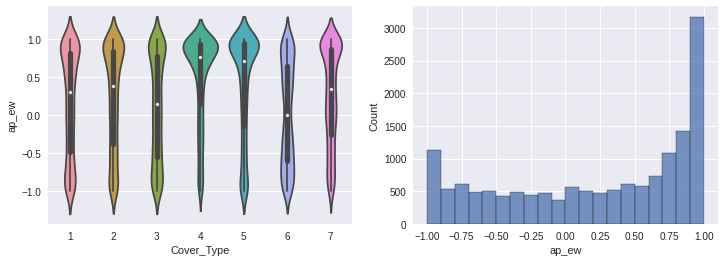

In [10]:
# Visualize cover type VS the cosine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ew'],ax=ax1)
sns.histplot(train_df['ap_ew'],ax=ax2)
plt.show()

After the feature transformation, we see improved distinction in median values, espeically for cover type 6, where the median is notably higher than that of other cover types and the distribution is concentrated around the median.

#### Segment data

Based on closer examination of our model performance, we found that the models consistently confused cover types 1 and 2 and covertypes 3 and 6. So we decided to break up our model into one primary model (outputs 12 (for 1 or 2), 36 (for outputs 3 or 6), 4, 5 or 7) and two secondary models (one for distinguishing 1 or 2 and the other for distinguishing 3 or 6). 

In [11]:
# Split trainning data into subsets to improve model accurracy with cover type 1&2, and 3&6.
train_df_original, train_df_12_36_4_5_7, train_df_12, train_df_36 = fe.subset_data(train_df)

#### Split data into train/dev

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [12]:
# Only (randomly) sample indicies once for the entire dataset 
# This will be very important for comparing the output to the original dev labels 
train_indicies_all_data = list(train_df_original.sample(frac=0.8).index)

# Split each dataset into 80% train and 20% dev by randomly sampling indicies 
train_data_original, train_labels_original, dev_data_original, dev_labels_original = fe.split_data(train_df_original,train_indicies_all_data)
train_data_12_36_4_5_7, train_labels_12_36_4_5_7, dev_data_12_36_4_5_7, dev_labels_12_36_4_5_7 = fe.split_data(train_df_12_36_4_5_7,train_indicies_all_data)
train_data_cover_type_12, train_labels_cover_type_12, dev_data_cover_type_12, dev_labels_cover_type_12  = fe.split_data(train_df_12,list(train_df_12.sample(frac=0.8).index))
train_data_cover_type_36, train_labels_cover_type_36, dev_data_cover_type_36, dev_labels_cover_type_36  = fe.split_data(train_df_36,list(train_df_36.sample(frac=0.8).index))

#### Scale the data to have a mean of 0 and a variance of 1.

In [13]:
standardize_features = ['Elevation','Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points','Elevation_squared']

# Retrieve scaler *once* for the original training data so we don't overfit the smaller datasets 
train_data_original, train_data_original_scaler = fe.scale_training_data(standardize_features, train_data_original, scaler_type="standard")
dev_data_original = fe.scale_non_training_data(standardize_features, dev_data_original, train_data_original_scaler)

train_data_12_36_4_5_7 = fe.scale_non_training_data(standardize_features, train_data_12_36_4_5_7, train_data_original_scaler)
dev_data_12_36_4_5_7 = fe.scale_non_training_data(standardize_features, dev_data_12_36_4_5_7, train_data_original_scaler)

train_data_cover_type_12 = fe.scale_non_training_data(standardize_features, train_data_cover_type_12, train_data_original_scaler)
dev_data_cover_type_12 = fe.scale_non_training_data(standardize_features, dev_data_cover_type_12, train_data_original_scaler)

train_data_cover_type_36 = fe.scale_non_training_data(standardize_features, train_data_cover_type_36, train_data_original_scaler)
dev_data_cover_type_36 = fe.scale_non_training_data(standardize_features, dev_data_cover_type_36, train_data_original_scaler)

#### Explore and confirm the shape of the data

In [14]:
print("Original Data with Labels 1,2,3,4,5,6,7")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_original.shape, train_labels_original.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_original.shape, dev_labels_original.shape))

print("Data with Labels 12,36,4,5,7")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_12_36_4_5_7.shape, train_labels_12_36_4_5_7.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_12_36_4_5_7.shape, dev_labels_12_36_4_5_7.shape))

print("Data with Labels 1,2")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_cover_type_12.shape, train_labels_cover_type_12.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_cover_type_12.shape, dev_labels_cover_type_12.shape))

print("Data with Labels 1,3")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_cover_type_36.shape, train_labels_cover_type_36.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_cover_type_36.shape, dev_labels_cover_type_36.shape))

Original Data with Labels 1,2,3,4,5,6,7
Training data shape: (12096, 54) Training labels shape: (12096,)
Dev data shape: (3024, 54) Dev labels shape: (3024,)

Data with Labels 12,36,4,5,7
Training data shape: (12096, 54) Training labels shape: (12096,)
Dev data shape: (3024, 54) Dev labels shape: (3024,)

Data with Labels 1,2
Training data shape: (3456, 54) Training labels shape: (3456,)
Dev data shape: (864, 54) Dev labels shape: (864,)

Data with Labels 1,3
Training data shape: (3456, 54) Training labels shape: (3456,)
Dev data shape: (864, 54) Dev labels shape: (864,)



## Models

Fit Random Forest, K Nearest Neighbors and Multilayer Perceptron models to the training data
<img src="data/training_models.png">

#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Set model parameters
num_trees = 100
max_depth = 8

# Fit a Random Forest Model to all of the training data
forest_model_all_data = RandomForestClassifier(num_trees, max_depth=max_depth)
forest_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# # Fit a Random Forest Model to differentiate cover types one and two
forest_model_cover_type_12 = RandomForestClassifier(num_trees, max_depth=max_depth)
forest_model_cover_type_12.fit(train_data_cover_type_12, train_labels_cover_type_12)

# # Fit a Random Forest Model to differentiate cover types three and six
forest_model_cover_type_36 = RandomForestClassifier(num_trees, max_depth=max_depth)
forest_model_cover_type_36.fit(train_data_cover_type_36, train_labels_cover_type_36)

RandomForestClassifier(max_depth=8)

#### K-Nearest Neighbors

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Set model parameters
num_neighbors = 1

# Fit a KNN Model to all of the training data
knn_model_all_data = KNeighborsClassifier(num_neighbors)
knn_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# Fit a KNN Model to differentiate cover types one and two
knn_model_cover_type_12 = KNeighborsClassifier(num_neighbors)
knn_model_cover_type_12.fit(train_data_cover_type_12, train_labels_cover_type_12)

# Fit a KNN Model to differentiate cover types three and six
knn_model_cover_type_36 = KNeighborsClassifier(num_neighbors)
knn_model_cover_type_36.fit(train_data_cover_type_36, train_labels_cover_type_36)

KNeighborsClassifier(n_neighbors=1)

#### Multi-Layer Perceptron

In [17]:
from sklearn.neural_network import MLPClassifier

# Set model parameters
alpha = 1e-3
hidden_layer_sizes = (200,)
random_state = 0
max_iter = 200

# Fit a KNN Model to all of the training data
mlp_model_all_data = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# # Fit a KNN Model to differentiate cover types one and two
mlp_model_cover_type_12 = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_cover_type_12.fit(train_data_cover_type_12, train_labels_cover_type_12)

# # Fit a KNN Model to differentiate cover types three and six
mlp_model_cover_type_36 = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_cover_type_36.fit(train_data_cover_type_36, train_labels_cover_type_36)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(200,), random_state=0)

#### Neural Network (will replace MLP if it performs better)
##### TODO: Work In Progress

In [37]:
# import tensorflow as tf 

# # Create a model for labels 12,36,4,5,7
# nn_model_all = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(54,)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10)
# ])

# nn_model_all.fit(train_data_12_36_4_5_7.to_numpy(), train_labels_12_36_4_5_7.to_numpy(), epochs=5)

# # Create a model for labels 1,2
# nn_model_12 = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(54,)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10)
# ])

# nn_model_12.fit(train_data_cover_type_12.to_numpy(), train_labels_cover_type_12.to_numpy(), epochs=5)

# # Create a model for labels 3,6
# nn_model_36 = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(54,)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10)
# ])

# nn_model_36.fit(train_data_cover_type_36.to_numpy(), train_labels_cover_type_36.to_numpy(), epochs=5)

## Evaluation

Predictions from each model are producted accordingly (for both dev and test)
<img src="data/predictions.png">

#### Evaluate Random Forest Model 

In [18]:
forest_predictions_all_data = forest_model_all_data.predict(dev_data_12_36_4_5_7)
print("Random Forest Perforamance (against 12/36 dev labels) - Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), forest_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
forest_predicted_12_indicies = np.where(forest_predictions_all_data==12)
forest_predicted_36_indicies = np.where(forest_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
forest_predictions_1_2 = forest_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[forest_predicted_12_indicies])
forest_predictions_3_6 = forest_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[forest_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
forest_predictions_all_data[forest_predicted_12_indicies] = forest_predictions_1_2
forest_predictions_all_data[forest_predicted_36_indicies] = forest_predictions_3_6

print("Random Forest Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), forest_predictions_all_data.reshape(-1, 1)))

Random Forest Perforamance (against 12/36 dev labels) - Model 1:  0.8792989417989417
Random Forest Perforamance Against Real Dev Labels - Overall Score:  0.7913359788359788


#### Evaluate KNN Model

In [19]:
knn_predictions_all_data = knn_model_all_data.predict(dev_data_12_36_4_5_7)
print("KNN Perforamance (against 12/36 dev labels) - Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), knn_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
knn_predicted_12_indicies = np.where(knn_predictions_all_data==12)
knn_predicted_36_indicies = np.where(knn_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
knn_predictions_1_2 = knn_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[knn_predicted_12_indicies])
knn_predictions_3_6 = knn_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[knn_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
knn_predictions_all_data[knn_predicted_12_indicies] = knn_predictions_1_2
knn_predictions_all_data[knn_predicted_36_indicies] = knn_predictions_3_6

print("KNN Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), knn_predictions_all_data.reshape(-1, 1)))

KNN Perforamance (against 12/36 dev labels) - Model 1:  0.9166666666666666
KNN Perforamance Against Real Dev Labels - Overall Score:  0.9001322751322751


#### Evaluate MLP Model

In [20]:
mlp_predictions_all_data = mlp_model_all_data.predict(dev_data_12_36_4_5_7)
print("MLP Perforamance (against 12/36 dev labels)- Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), mlp_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
mlp_predicted_12_indicies = np.where(mlp_predictions_all_data==12)
mlp_predicted_36_indicies = np.where(mlp_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
mlp_predictions_1_2 = knn_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[mlp_predicted_12_indicies])
mlp_predictions_3_6 = knn_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[mlp_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
mlp_predictions_all_data[mlp_predicted_12_indicies] = mlp_predictions_1_2
mlp_predictions_all_data[mlp_predicted_36_indicies] = mlp_predictions_3_6

print("MLP Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), mlp_predictions_all_data.reshape(-1, 1)))

MLP Perforamance (against 12/36 dev labels)- Model 1:  0.939484126984127
MLP Perforamance Against Real Dev Labels - Overall Score:  0.9232804232804233


#### Evaluate Neural Network (will replace MLP if it performs better)
##### TODO: Work In Progress

In [38]:
# # Retrieve predictions for dev_data with labels 12,36,4,5,7
# nn_predictions_all_data = nn_model_all(dev_data_12_36_4_5_7.to_numpy())

# # Retrieve examples where the model predicted 12 or 36
# nn_predictioned_12_indicies = np.where(nn_predictions_all_data==12)
# nn_predictioned_36_indicies = np.where(nn_predictions_all_data==36)

# # Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
# nn_predictions_1_2 = nn_model_12(np.array(dev_data_12_36_4_5_7)[nn_predictioned_12_indicies].to_numpy())
# nn_predictions_3_6 = nn_model_36(np.array(dev_data_12_36_4_5_7)[nn_predictioned_36_indicies].to_numpy())

# # Update those 12 or 36 labels to be 1,2,3,6
# nn_predictions_all_data[nn_predictioned_12_indicies] = nn_predictions_1_2
# nn_predictions_all_data[nn_predictioned_36_indicies] = nn_predictions_3_6

# # Convert logits to probabilities for 12,36,4,5,7
# tf.nn.softmax(predictions).numpy()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer='adam',
#               loss=loss_fn,
#               metrics=['accuracy'])

# # Retrieve predictions
# predictions = model(train_data_12_36_4_5_7.to_numpy())



# model.evaluate(dev_data_12_36_4_5_7.to_numpy(), dev_labels.to_numpy(), verbose=2)

#### Ensemble
Here we will combine the three best performing models and implement a "voting" system to try to improve accuracy.
<img src="data/ensemble.png">

In [21]:
new_predictions = models.ensemble(forest_predictions_all_data, knn_predictions_all_data, mlp_predictions_all_data)
accuracy = accuracy_score(dev_labels_original, new_predictions)
print("Ensemble Accuracy: ", accuracy)

Models disagreed on 718/3024 examples.
Ensemble Accuracy:  0.9222883597883598


### Test Results

In [22]:
# Read in testing data 
test_data = pd.read_csv("data/test.csv")

# Preserve testing df ID for submission purpose
test_df_id = test_data["Id"]

In [23]:
# Apply Same Transformations 
test_data = fe.manipulate_data(test_data)
test_data = fe.scale_non_training_data(standardize_features, test_data, train_data_original_scaler)

In [24]:
# Verify shape
print("Testing data shape: ", test_data.shape)

Testing data shape:  (565892, 54)


#### Test Random Forest

In [25]:
test_forest_predictions = forest_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_forest_predicted_12_indicies = np.where(test_forest_predictions==12)
test_forest_predicted_36_indicies = np.where(test_forest_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
test_forest_predictions_1_2 = forest_model_cover_type_12.predict(np.array(test_data)[test_forest_predicted_12_indicies])
test_forest_predictions_3_6 = forest_model_cover_type_36.predict(np.array(test_data)[test_forest_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_forest_predictions[test_forest_predicted_12_indicies] = test_forest_predictions_1_2
test_forest_predictions[test_forest_predicted_36_indicies] = test_forest_predictions_3_6

#### Test KNN

In [26]:
test_knn_predictions = knn_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_knn_predicted_12_indicies = np.where(test_knn_predictions==12)
test_knn_predicted_36_indicies = np.where(test_knn_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
test_knn_predictions_1_2 = knn_model_cover_type_12.predict(np.array(test_data)[test_knn_predicted_12_indicies])
test_knn_predictions_3_6 = knn_model_cover_type_36.predict(np.array(test_data)[test_knn_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_knn_predictions[test_knn_predicted_12_indicies] = test_knn_predictions_1_2
test_knn_predictions[test_knn_predicted_36_indicies] = test_knn_predictions_3_6

#### Test MLP

In [27]:
test_mlp_predictions = mlp_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_mlp_predicted_12_indicies = np.where(test_mlp_predictions==12)
test_mlp_predicted_36_indicies = np.where(test_mlp_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
test_mlp_predictions_1_2 = mlp_model_cover_type_12.predict(np.array(test_data)[test_mlp_predicted_12_indicies])
test_mlp_predictions_3_6 = mlp_model_cover_type_36.predict(np.array(test_data)[test_mlp_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_mlp_predictions[test_mlp_predicted_12_indicies] = test_mlp_predictions_1_2
test_mlp_predictions[test_mlp_predicted_36_indicies] = test_mlp_predictions_3_6

#### Test NN (will replace MLP if it performs better)
##### TODO: Work In Progress

In [36]:
# TODO once evaluate is done (do the same thing on the test data)

#### Test Ensemble

In [28]:
new_predictions = models.ensemble(test_forest_predictions, test_knn_predictions, test_mlp_predictions)

Models disagreed on 238576/565892 examples.


#### Generate Submission File

In [29]:
result = pd.DataFrame.from_dict(dict(zip(test_df_id.to_list(),new_predictions)), orient='index', columns=["Cover_Type"])
result.to_csv(f"submissions/cobsolidated_submission.csv",index_label="Id")

### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [30]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear_cut_solution.ipynb --to="python" --output="backups/clear_cut_solution"
!jupyter nbconvert clear_cut_solution.ipynb --to markdown --output="backups/clear_cut_solution"

# Also archiving this bad boy
!jupyter nbconvert clear_cut_solution.ipynb --to html --output="backups/clear_cut_solution"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to python
[NbConvertApp] Writing 19916 bytes to backups/clear_cut_solution.py
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear_cut_solution_files/
[NbConvertApp] Making directory backups/clear_cut_solution_files/backups
[NbConvertApp] Writing 24600 bytes to backups/clear_cut_solution.md
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to html
[NbConvertApp] Writing 399829 bytes to backups/clear_cut_solution.html
